In [54]:
import pandas as pd
from tqdm import tqdm
import pathlib
import settings
import os
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [47]:
MEASURE_NAME = "perc_w_int_100_20_using_devices"


def generate_higher_geo(df, geoid_length=11):
    region_type = settings.FIPS_LENGTH_DESIGNATION[geoid_length]
    df[region_type] = df["geoid"].str[:geoid_length]
    cdf = (
        df.groupby([region_type, "year"])["value"].agg("mean").to_frame().reset_index()
    )
    cdf["measure"] = MEASURE_NAME
    # rename the census tract back into geoid to concat
    cdf = cdf.rename(columns={region_type: "geoid"})
    cdf = cdf.reindex(settings.STANDARD_COLS, axis="columns")
    cdf["region_type"] = region_type
    return cdf

export_dir = (
    "../data/Accessibility/Percent Fast (internet-connected)/data/distribution"
)
ookla_files = sorted(pathlib.Path(settings.OOKLA_DATA_DIR).glob("*.csv.xz"))
acs_1_files = sorted(
    pathlib.Path("../sdc.broadband.acs/data/distribution/B28002_001").glob(
        "*.csv.xz"
    )
)
acs_13_files = sorted(
    pathlib.Path("../sdc.broadband.acs/data/distribution/B28002_013").glob(
        "*.csv.xz"
    )
)

overlapped_filenames = sorted(
    set([f.name for f in ookla_files]).intersection(
        set([f.name for f in acs_1_files]).intersection(
            set([f.name for f in acs_13_files])
        )
    )
)

# Filter for only overlapping files between the data sets
ookla_files = [f for f in ookla_files if f.name in overlapped_filenames]
acs_1_files = [f for f in acs_1_files if f.name in overlapped_filenames]
acs_13_files = [f for f in acs_13_files if f.name in overlapped_filenames]

In [48]:
print(ookla_files[0])
print(acs_1_files[0])
print(acs_13_files[0])

../sdc.broadband.ookla/data/distribution/01001.csv.xz
../sdc.broadband.acs/data/distribution/B28002_001/01001.csv.xz
../sdc.broadband.acs/data/distribution/B28002_013/01001.csv.xz


In [50]:
ookla_f = ookla_files[0]
acs1_f = acs_1_files[0]
acs13_f = acs_13_files[0]

ookla_df = pd.read_csv(ookla_f, dtype={"GEOID20": object})
# Preparing bbn file; remove all not nulls but also the specific none-standard values
ookla_df = ookla_df.dropna()
ookla_df = ookla_df.rename(columns={"GEOID20": "geoid"})

ookla_df

,geoid,avg_d_mbps,avg_u_mbps,tests,devices,avg_lat_ms,year,q
0,010010208032004,300.460,346.816,2,2,2,2022,1
1,010010208032004,420.402,540.529,1,1,3,2022,1
2,010010208032004,453.762,644.528,4,1,3,2022,1
3,010010208032004,209.799,211.998,2,2,1,2022,1
4,010010208032004,456.482,550.670,3,1,2,2022,1
...,...,...,...,...,...,...,...,...
9215,010010207003002,15.327,9.903,3,2,26,2022,4
9216,010010207003031,440.002,21.072,2,1,37,2022,4
9217,010010207003028,337.272,312.214,10,3,17,2022,4
9218,010010205011028,337.272,312.214,10,3,17,2022,4


<Axes: xlabel='avg_d_mbps'>

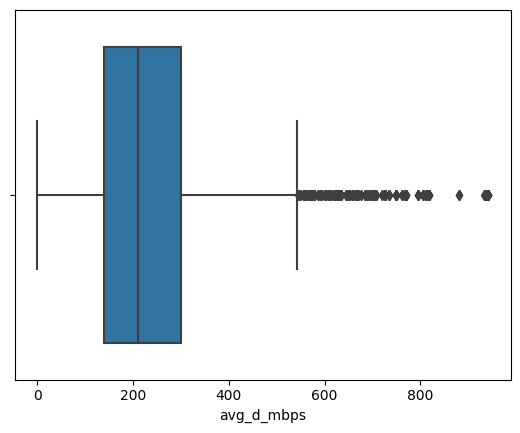

In [52]:
sns.boxplot(x='avg_d_mbps', data=ookla_df)

<Axes: xlabel='avg_d_mbps', ylabel='Density'>

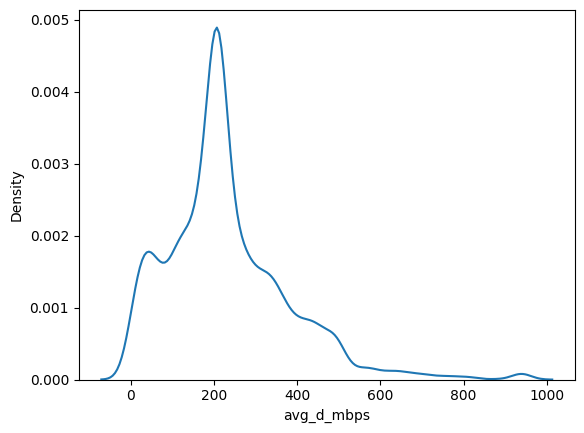

In [58]:
sns.kdeplot(data=ookla_df, x="avg_d_mbps")

<Axes: xlabel='avg_u_mbps', ylabel='Density'>

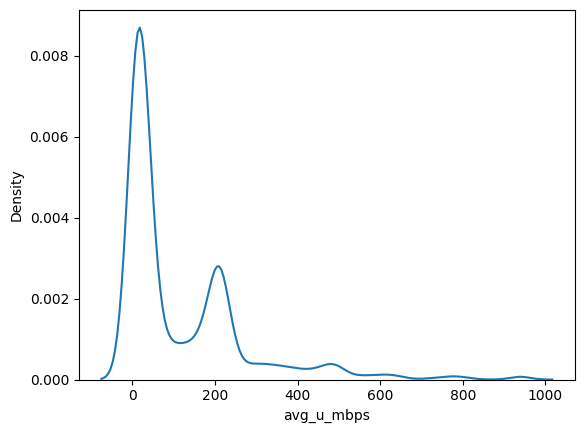

In [59]:
sns.kdeplot(data=ookla_df, x="avg_u_mbps")

In [73]:
# https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
# Get the frequency, PDF and CDF for each value in the series

def calculate_stats_df(df, value_col = 'value'):
    # Frequency
    stats_df = df \
    .groupby(value_col) \
    [value_col] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {value_col: 'frequency'})
    
    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    
    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    return stats_df

In [100]:
def calculate_cpdf(df, value_col = 'value', cutoff=25, tail=True):
    # Frequency
    stats_df = df \
    .groupby(value_col) \
    [value_col] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {value_col: 'frequency'})

    if stats_df.empty:
        return None
    
    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    
    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    if tail:
        return 1 - stats_df[stats_df[value_col] >= cutoff].min()['cdf']
    else:
        return stats_df[stats_df[value_col] >= cutoff].min()['cdf']

In [77]:
up_stats_df = calculate_stats_df(ookla_df, 'avg_u_mbps')
up_stats_df

,avg_u_mbps,frequency,pdf,cdf
0,0.162,3,0.000325,0.000325
1,0.212,2,0.000217,0.000542
2,0.213,3,0.000325,0.000868
3,0.223,1,0.000108,0.000976
4,0.238,3,0.000325,0.001302
...,...,...,...,...
2086,939.240,2,0.000217,0.998915
2087,939.244,1,0.000108,0.999024
2088,939.415,2,0.000217,0.999241
2089,939.935,1,0.000108,0.999349


In [78]:
1 - up_stats_df[up_stats_df['avg_u_mbps'] > 25].min()['cdf'] # get the probability on the right side

0.5133405639913242

In [80]:
down_stats_df = calculate_stats_df(ookla_df, 'avg_d_mbps')
down_stats_df

,avg_d_mbps,frequency,pdf,cdf
0,0.305,5,0.000542,0.000542
1,0.934,1,0.000108,0.000651
2,1.029,3,0.000325,0.000976
3,1.205,2,0.000217,0.001193
4,1.538,4,0.000434,0.001627
...,...,...,...,...
2135,940.057,1,0.000108,0.998807
2136,940.080,1,0.000108,0.998915
2137,940.409,2,0.000217,0.999132
2138,941.790,6,0.000651,0.999783


In [82]:
combined_prob = (1 - up_stats_df[up_stats_df['avg_u_mbps'] >= 25].min()['cdf']) * (1 - down_stats_df[down_stats_df['avg_d_mbps'] >= 100].min()['cdf'])

In [83]:
combined_prob

0.426206292554619

In [ ]:
# ookla_f = ookla_files[0]
# acs1_f = acs_1_files[0]
# acs13_f = acs_13_files[0]

In [88]:
acs1_df = pd.read_csv(acs1_f, dtype={"GEOID21": object})
acs1_df = acs1_df.rename(columns={"GEOID21": "geoid"})
acs1_df["year"] = 2021
a1df = (
    acs1_df.groupby(["geoid", "year"])["B28002_001E"]
    .agg("min")
    .to_frame()
    .reset_index()
)
a1df = a1df[a1df["B28002_001E"] > 0]
a1df[
    "year"
] = 2023  # TBD should be adjusted for inflation for moving forward in time?
a1df

,geoid,year,B28002_001E
0,010010201001,2023,252.0
1,010010201002,2023,357.0
2,010010202001,2023,272.0
3,010010202002,2023,328.0
4,010010203001,2023,947.0
5,010010203002,2023,399.0
6,010010204001,2023,241.0
7,010010204002,2023,776.0
8,010010204003,2023,335.0
9,010010204004,2023,254.0


In [91]:
acs13_df = pd.read_csv(acs13_f, dtype={"GEOID21": object})
acs13_df = acs13_df.rename(columns={"GEOID21": "geoid"})
acs13_df["year"] = 2021
a13df = (
    acs13_df.groupby(["geoid", "year"])["B28002_013E"]
    .agg("min")
    .to_frame()
    .reset_index()
)
a13df = a13df[a13df["B28002_013E"] > 0]
a13df[
    "year"
] = 2023  # TBD should be adjusted for inflation for moving forward in time?
a13df

,geoid,year,B28002_013E
0,010010201001,2023,52.0
1,010010201002,2023,36.0
2,010010202001,2023,37.0
3,010010202002,2023,77.0
4,010010203001,2023,85.0
5,010010203002,2023,108.0
7,010010204002,2023,9.0
8,010010204003,2023,62.0
9,010010204004,2023,50.0
10,010010205011,2023,38.0


In [105]:
bg_df = pd.merge(a1df, a13df, on=["geoid", "year"])
bg_df

,geoid,year,B28002_001E,B28002_013E
0,010010201001,2023,252.0,52.0
1,010010201002,2023,357.0,36.0
2,010010202001,2023,272.0,37.0
3,010010202002,2023,328.0,77.0
4,010010203001,2023,947.0,85.0
5,010010203002,2023,399.0,108.0
6,010010204002,2023,776.0,9.0
7,010010204003,2023,335.0,62.0
8,010010204004,2023,254.0,50.0
9,010010205011,2023,894.0,38.0


# For each geography, generate the cdf

In [106]:
ookla_df

,geoid,avg_d_mbps,avg_u_mbps,tests,devices,avg_lat_ms,year,q
0,010010208032004,300.460,346.816,2,2,2,2022,1
1,010010208032004,420.402,540.529,1,1,3,2022,1
2,010010208032004,453.762,644.528,4,1,3,2022,1
3,010010208032004,209.799,211.998,2,2,1,2022,1
4,010010208032004,456.482,550.670,3,1,2,2022,1
...,...,...,...,...,...,...,...,...
9215,010010207003002,15.327,9.903,3,2,26,2022,4
9216,010010207003031,440.002,21.072,2,1,37,2022,4
9217,010010207003028,337.272,312.214,10,3,17,2022,4
9218,010010205011028,337.272,312.214,10,3,17,2022,4


In [107]:
bg_df['upload_prob'] = bg_df['geoid'].apply(lambda x: calculate_cpdf(ookla_df[ookla_df['geoid'].str[:len(x)]== x], 'avg_u_mbps' ,25))
bg_df['download_prob'] = bg_df['geoid'].apply(lambda x: calculate_cpdf(ookla_df[ookla_df['geoid'].str[:len(x)]== x], 'avg_d_mbps',100))
bg_df

,geoid,year,B28002_001E,B28002_013E,upload_prob,download_prob
0,010010201001,2023,252.0,52.0,0.269231,0.615385
1,010010201002,2023,357.0,36.0,0.187793,0.690141
2,010010202001,2023,272.0,37.0,0.142857,0.767857
3,010010202002,2023,328.0,77.0,0.380282,0.661972
4,010010203001,2023,947.0,85.0,0.155963,0.889908
5,010010203002,2023,399.0,108.0,0.136364,0.738636
6,010010204002,2023,776.0,9.0,0.105058,0.871595
7,010010204003,2023,335.0,62.0,0.054348,0.750000
8,010010204004,2023,254.0,50.0,0.205882,0.705882
9,010010205011,2023,894.0,38.0,0.441358,0.898148


In [108]:
bg_df["measure"] = MEASURE_NAME
bg_df["value"] = (
    bg_df["upload_prob"] * bg_df["download_prob"] * (bg_df["B28002_001E"] - bg_df["B28002_013E"])/ (bg_df["B28002_001E"].sum() - bg_df["B28002_013E"].sum()) * 100
)
bg_df = bg_df.reindex(settings.STANDARD_COLS, axis="columns")
bg_df["region_type"] = "block_group"
bg_df

,geoid,measure,moe,value,year,region_type
0,010010201001,perc_w_int_100_20_using_devices,NaN,0.211152,2023,block_group
1,010010201002,perc_w_int_100_20_using_devices,NaN,0.265105,2023,block_group
2,010010202001,perc_w_int_100_20_using_devices,NaN,0.164265,2023,block_group
3,010010202002,perc_w_int_100_20_using_devices,NaN,0.402636,2023,block_group
4,010010203001,perc_w_int_100_20_using_devices,NaN,0.762376,2023,block_group
5,010010203002,perc_w_int_100_20_using_devices,NaN,0.186774,2023,block_group
6,010010204002,perc_w_int_100_20_using_devices,NaN,0.447543,2023,block_group
7,010010204003,perc_w_int_100_20_using_devices,NaN,0.070909,2023,block_group
8,010010204004,perc_w_int_100_20_using_devices,NaN,0.188919,2023,block_group
9,010010205011,perc_w_int_100_20_using_devices,NaN,2.162254,2023,block_group


In [ ]:
# # Generating summaries at a census tract level
# ct_df = generate_higher_geo(bg_df, 11)
# c_df = generate_higher_geo(bg_df, 5)

# fdf = pd.concat([c_df, ct_df, bg_df])
# fdf = fdf.reindex(settings.STANDARD_COLS, axis="columns")
# export_filepath = os.path.join(export_dir, acs_f.name)
# pbar.set_description("Exporting to: %s" % export_filepath)
# assert not any(fdf["geoid"].isnull())  # Sanity check
# # fdf.to_csv(export_filepath, index=False)